<a href="https://colab.research.google.com/github/AnaGutson/AlgebraII/blob/main/Redes_Neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **General**

Todo está escrito con un ejemplo, para mostrar una forma de realizar cada cosa

## Carga de dataset a la notebook


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
ds_titanic = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titanic.csv')
ds_trabajo = ds_titanic.copy()

## **Tensor Flow**

Biblioteca que se utiliza para trabajar en ciencia de datos, en específico con redes neuronales.

Desarrollada por Google Brain.

Se utiliza en:
- Google Photos
- Google Search Engine
- Google Cloud Speech

Características:
- Soporte similar a NumPy con soporte específico para GPU!
- Compatible con computación distribuida.
- Incluya su propio compilador JIT (optimiza los calculos, descomponiendolos y ejecutandolos en paralelo).

Arquitectura:

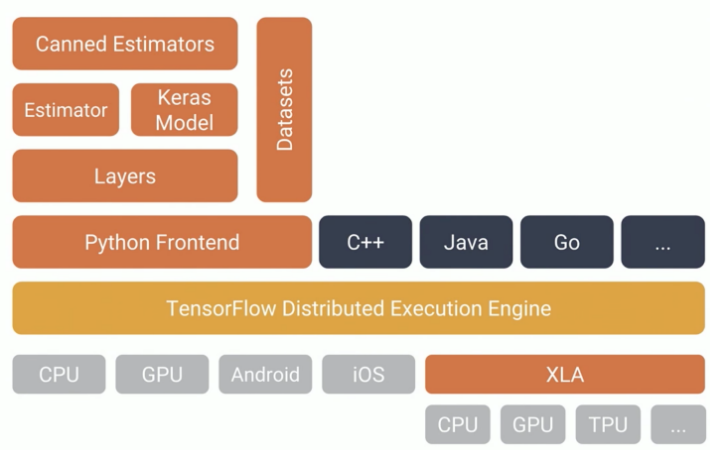



In [ ]:
import tensorflow as tf

**Constantes**

In [ ]:
#crear constante
a = tf.constant([2])
b = tf.constant([3])

matrix_one = tf.constant([[1,2,3],[2,3,4],[3,4,5]])
matrix_two = tf.constant([[2,2,2],[2,2,2],[2,2,2]])

#operaciones
suma = tf.add(a,b) #mismo que hacer a + b
mult = tf.matmul(matrix_one, matrix_two)
cuadrado = tf.square(matrix_one)

suma, a+b, mult, cuadrado

**Variables**

In [ ]:
#crear constante
v = tf.Variable([[1,2,3],[4,5,6]])

#cambios de la variable
v.assign(2*v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=int32, numpy=
array([[ 2,  4,  6],
       [ 8, 10, 12]], dtype=int32)>

Al realizar una operación, internamente Tensor Flow define un grafo.

Internamente no se va a ejecutar línea por línea (como se hace habitualmente), sino que primero se arma un modelo en memoria con todas las operaciones que se le indiquen.

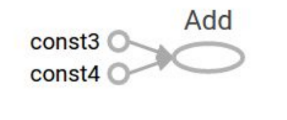

**Tensores**

Un tensor es una matriz de matrices.
Sin embargo, para Tensor Flow, todos son tensores. 

In [ ]:
Scalar = tf.constant([2])
Vector = tf.constant([5,6,2])
Matrix = tf.constant([[1,2,3],[2,3,4],[3,4,5]])
Tensor = tf.constant([ [[1,2,3],[2,3,4],[3,4,5]],
                       [[4,5,6],[5,6,7],[6,7,8]],
                       [[7,8,9],[8,9,10],[9,10,11]] ])

## Código para realizar predicción genérica


In [ ]:
#Se eliminan variables que no sirven
columnas_eliminar=['PassengerId','Name',"Ticket"]
ds_trabajo.drop(columnas_eliminar, axis='columns', inplace=True)  #Elimina columna sobre el mismo dataframe

#Se eliminan datos faltantes
columnas_eliminar_NANs=['Cabin']
ds_trabajo.drop(columnas_eliminar_NANs, axis='columns', inplace=True)
ds_trabajo=ds_trabajo.dropna()

#Se obtienen los sets de entrenamiento y test
ds_trabajo_x = ds_trabajo.drop(['Survived'], axis='columns', inplace=False)
ds_trabajo_y = ds_trabajo['Survived'].copy()
x_train, x_test, y_train, y_test = train_test_split(	ds_trabajo_x, 
                                                      ds_trabajo_y, 
	                                   		              test_size = 0.3,    		#30% al conjunto de test
	                                                  	random_state = 13, 	    #para poder reproducir el experimento
                  	                                	stratify=ds_trabajo_y)  #estratificado para mantener proporcion

#Se calcula el porcentaje de datos, tanto de entrenamiento como de test
pd.Series(y_train).value_counts(normalize=True)[1]*100
pd.Series(y_test).value_counts(normalize=True)[1]*100

#Se escalan los datos de entrenamiento con MinMaxScaler()
scaler = MinMaxScaler() 
scaler.fit(pd.DataFrame(x_train['Age']))
x_train['Age']=scaler.transform(x_train['Age'].to_frame())
x_test['Age']=scaler.transform(x_test['Age'].to_frame())

#Se entrena el modelo
model = #modelo
model.fit(X = x_train, y = y_train)

#Se hace la prediccion
y_pred = model.predict(x_test)

#Se crea un dataset nuevo para visualizarlo
ds_resultados = pd.DataFrame(zip(y_test, y_pred), columns=['test', 'pred'])
ds_resultados.head()

#Se puede visualizar en una matriz de confusion
tabla=confusion_matrix(ds_resultados['test'], ds_resultados['pred'])
grf=sns.heatmap(tabla,annot=True)
plt.show()

#Se pueden calcular las metricas
accuracy=accuracy_score(ds_resultados['test'], ds_resultados['pred'], normalize=True)
recall=recall_score(ds_resultados['test'], ds_resultados['pred'])
f1=f1_score(ds_resultados['test'], ds_resultados['pred'])

## **Búsqueda de hiperparámetros**

Se busca construir el "mejor" clasificador eligiendo los hiperparametros más adecuados mediante validación cruzada.

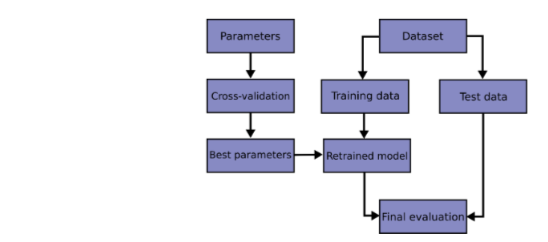

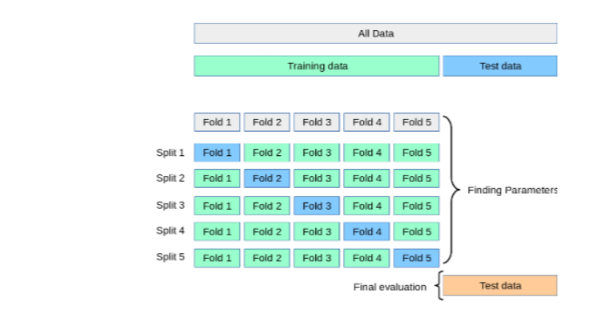

Para encontrar la mejor combinación de hiperparámetros, se explora un espacio de búsqueda, usando k-fold CV para medir el desempeño de cada combinación. Al terminar, se elige la combinación con mejor desempeño y se entrena un único modelo usando todos los datos de train.

Las exploraciones pueden ser:
- **Random Search**: explorar opciones y combinaciones al azar.
- **Grid Search**: se plantean y exploran todas las combinaciones.

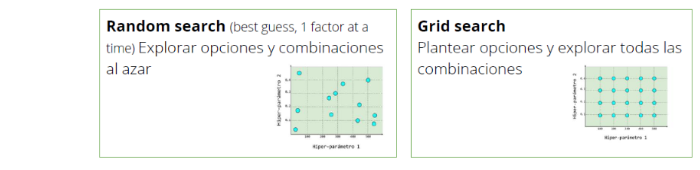

### Ejemplos


In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('always')
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer

#### Random Search con árbol

In [ ]:
#Cantidad de combinaciones que se quiere probar
n=20 

#Conjunto de parámetros que se quiere usar
params_grid = {'criterion': ['gini','entropy'],
               #'min_samples_leaf': list(range(1, 10)),
		           #'min_samples_split': list(range(2, 20)),
	             'ccp_alpha': np.linspace(0, 0.05, n), 
               'max_depth': list(range(1, 10))}

#Cantidad de splits para el Cross Validation
folds = 5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits = folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar: F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = base_tree,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv = kfoldcv,
                              n_iter = n) 

#Busco los hiperparametros que optimizan F1 Score
randomcv.fit(x_train,y_train)

#Mejores hiperparametros del árbol
randomcv.best_params_

#Mejor métrica
randomcv.best_score_

#Todas las métricas obtenidas
randomcv.cv_results_['mean_test_score']

#Atributos considerados y su importancia
best_tree = randomcv.best_estimator_
feat_imps = best_tree.feature_importances_
sorted(zip(feat_imps,ds_trabajo_x.columns.values))

#Me quedo con los mejores hiperparametros: opcion 1
tree_cv_best=gs_fit.best_estimator_
y_pred_tree_cv_best = tree_cv_best.predict(x_test)

#Me quedo con los mejores hiperparametros: opcion 2
params_elegidos=gs_fit.cv_results_['params'][np.argmax(gs_multimetrica_fit.cv_results_['mean_test_roc_auc'])]
base_tree = DecisionTreeClassifier(	criterion = params_elegidos['criterion'], 
              		 		ccp_alpha =   params_elegidos['ccp_alpha'],
               				max_depth =   params_elegidos['max_depth']	)
model = base_tree .fit(X = x_train, y = y_train)
y_pred_cv_best = model.predict(x_test)

#### Grid Search con árbol

In [ ]:
#Se crea un clasificador vacío
rf_cv = RandomForestClassifier(random_state=1, n_jobs=-1)

param_grid = {"criterion" : ["gini", "entropy"],
              "min_samples_leaf" : [1, 5, 10],
              "max_features":["sqrt", "log2"],
              "min_samples_split" : [2, 4, 10],
              "n_estimators": [10,20, 50] }

#Se prueba entrenando sólo con 1 métrica
gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring="roc_auc", cv=5, n_jobs=-1)

#Se entrena un modelo con la mejor combinacion de hiperparametros
gs_fit = gs.fit(X = x_train, y = y_train)
params_elegidos = gs_fit.cv_results_['params'][np.argmax(gs_fit.cv_results_['mean_test_roc_auc'])]
rfc = RandomForestClassifier(	criterion= params_elegidos['criterion'], 
			min_samples_leaf= params_elegidos['min_samples_leaf'], 
			min_samples_split= params_elegidos['min_samples_split'], 
			n_estimators=params_elegidos['n_estimators'], 
			max_features=params_elegidos["max_features"],
			random_state=2, n_jobs=-1)
model_rfc= rfc.fit(X = x_train, y = y_train)
y_pred_model_rfc = model_rfc.predict(x_test)

# **Redes Neuronales**

La mayoría son algoritmos supervisados.


**Funciones de activación. (entre otras)**

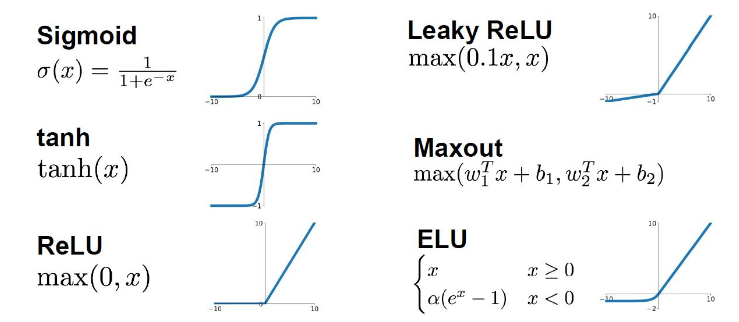

En general conviene normalizar los valores.
Si se normaliza:
- converge más rápido a la solución.
- puede llegar a una solución mejor.


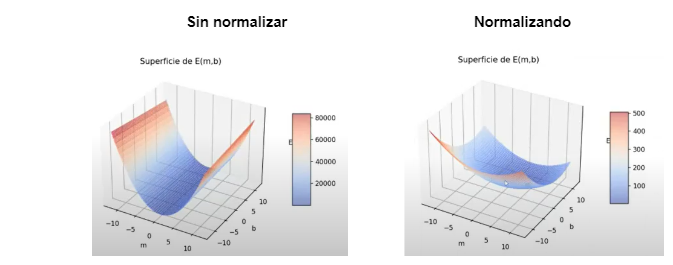

In [ ]:
columnas_predictoras=dataset_trabajo.columns.to_list()
columnas_predictoras.remove('target')

# Normalizo las variables de entrada
for col in columnas_predictoras:
    dataset_trabajo[col] =(dataset_trabajo.loc[:,col] -dataset_trabajo.loc[:,col].mean())/dataset_trabajo.loc[:,col].std()

**Comparación.** 

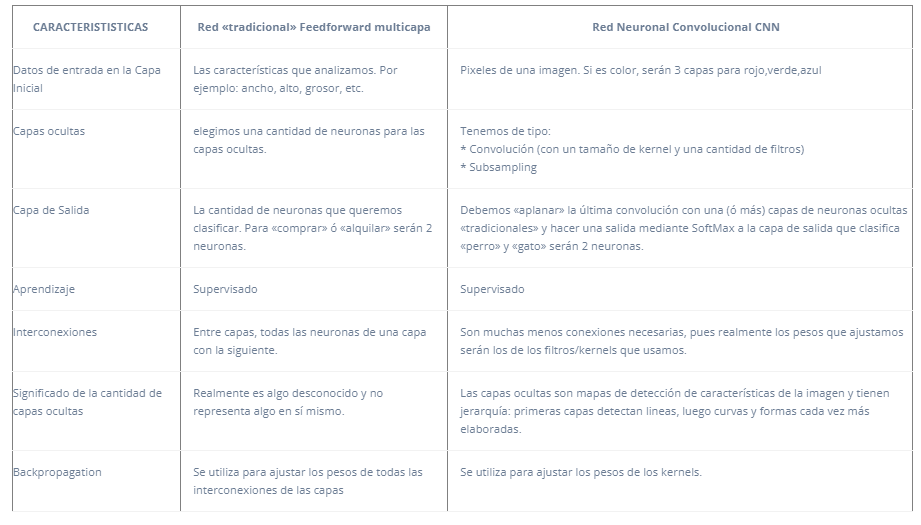

## **Perceptrón Simple**

Modelo de red neuronal más sencillo.

Es de una neurona.


### **Funcionamiento**

Se tienen entradas, a cada una se la multiplica por un peso. Cada resultado obtenido se suma, y se le agrega además un umbral. Dicho resultado se le envía a la función de activación, la cual decide si la neurona se activa o no.

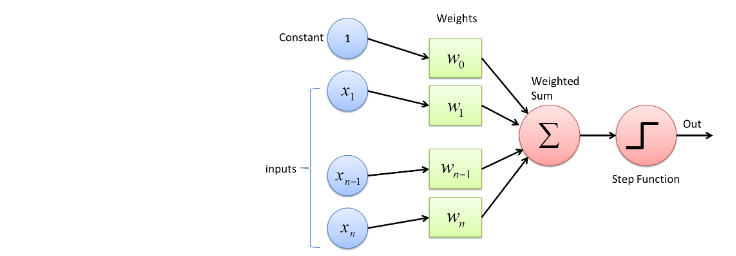

### **Funciones de activación**


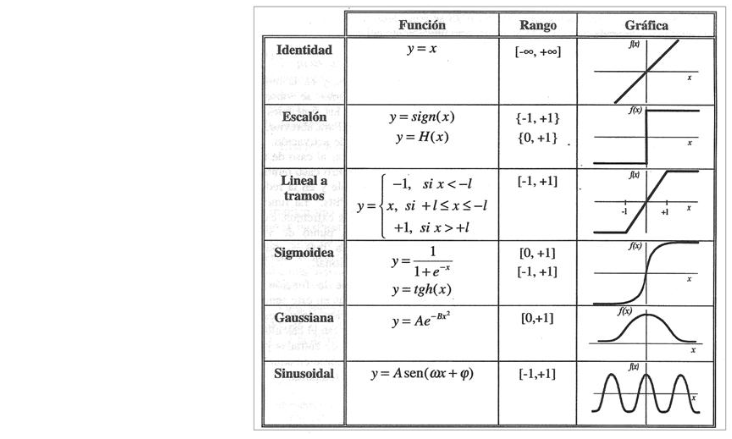

**Función escalón**

Cualquier valor menor o igual a 0 es 0, sino es 1.


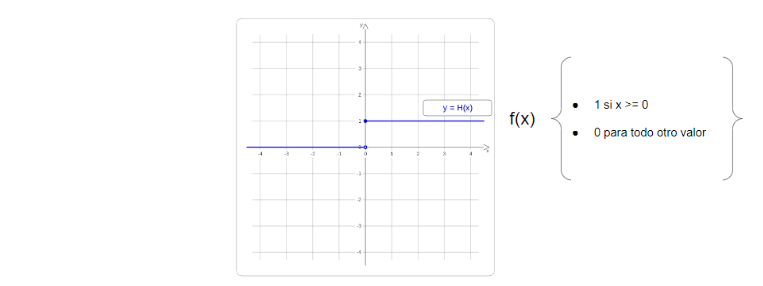

### **Ejemplo**

Quiero modelizar un AND, donde los datos son:


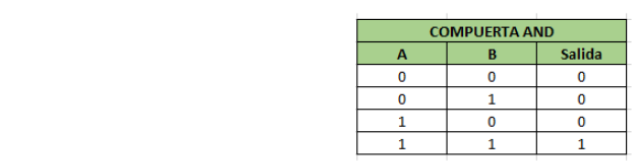

Por lo que se plantea lo siguiente:


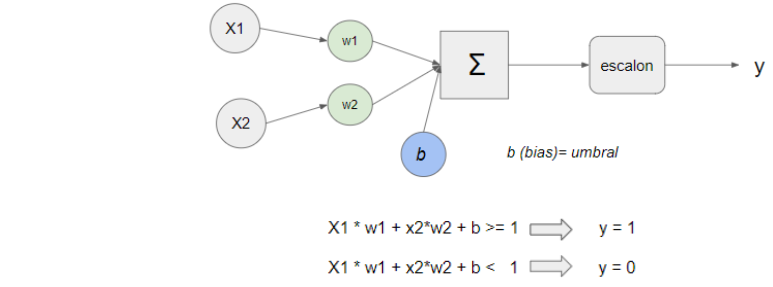

Se hacen las cuentas para cada combinación de $A$ y $B$:


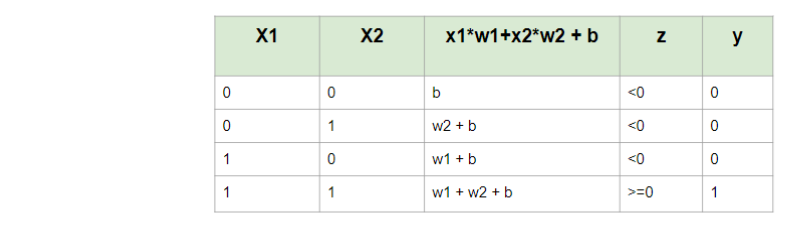

- Se eligen valores aleatorios de $w_1$, $w_2$ y $b$ (entre $0$ y $1$).
- Se hacen las cuentas a partir de estos valores aleatorios, prediciendo a partir de los resultados y comparando con el valor real. \\
Se tiene:
  - $z = $ resultado de la cuenta.
  - $y' = $ predicción.
  - $y = $ valor real.

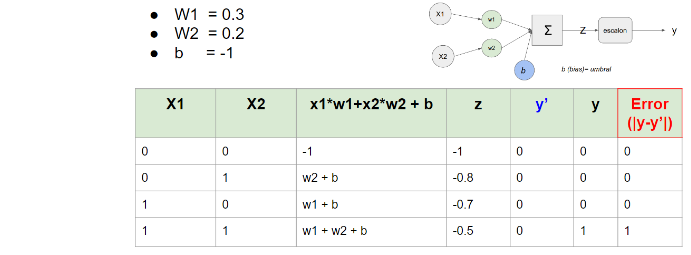

- Tengo un error así que grafico la función:

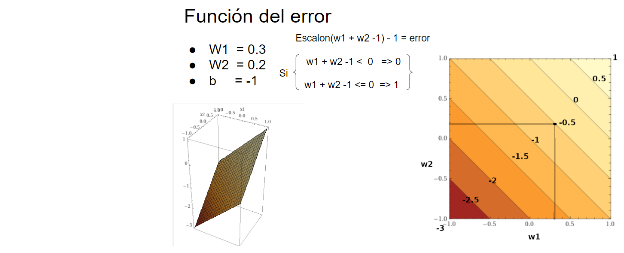

Le aplico la función escalón al gráfico:


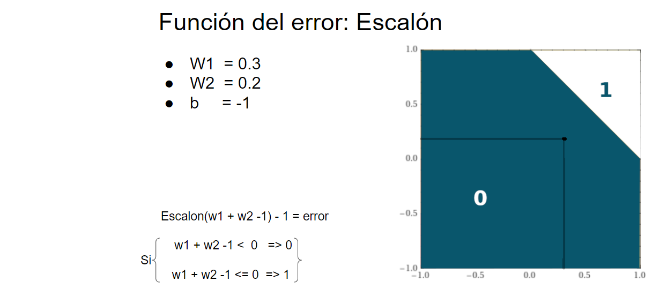

Sobre eso, le aplico la función error:

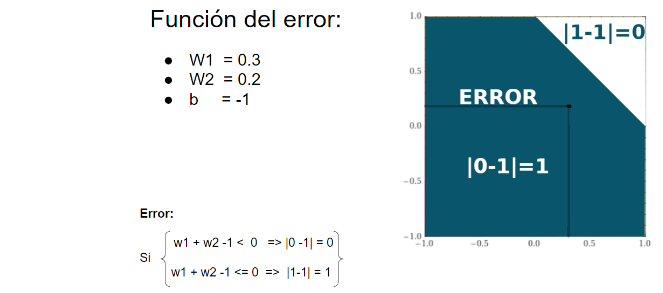

Hay que lograr acercarse a la zona blanca para lograr un error de $0$. Para esto se van a actualizar los pesos a partir de un parámetro $\alpha$: tasa de crecimiento. Es un valor entre $0$ y $1$, suele ser $0.5$

- Se actualizan los pesos con $\alpha = 0.2$. \\
Resulta: \\
$w_1 = 0.3 + 0.2 \times error,$ \\
$w_2 = 0.2 + 0.2 \times error,$ \\
$b = -1$, \\
siendo $error = 1$

- Se vuelven a hacer las cuentas:

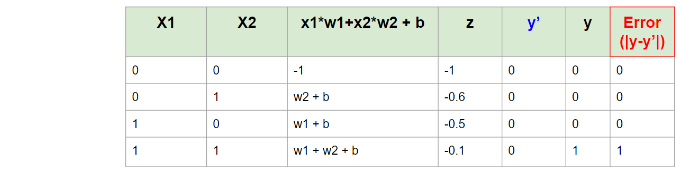

- Se continúa con la actualización de pesos hasta ya no tener un error.

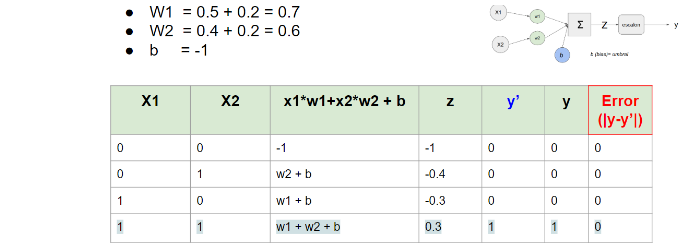

Finalmente ya se tiene una red neuronal entrenada que replica una compuerta AND.
Esta red neuronal funciona para los datos de entrenamiento y para cualquier conjunto nuevo de datos.

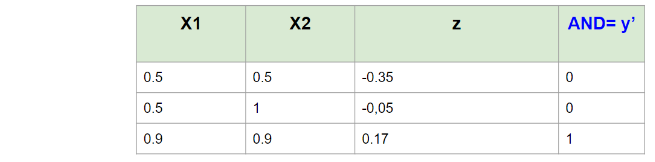

Geométricamente se puede pensar como un hiperplano en un espacio tetradimensional.

Si se ve en dos dimensiones, se puede pensar a la combinación de valores de A y B como coordenadas, y a la ecuación obtenida $(x_1 \cdot 0.7 + x_2 \cdot 0.6 - 1) $ como una recta que separa el espacio en dos partes:

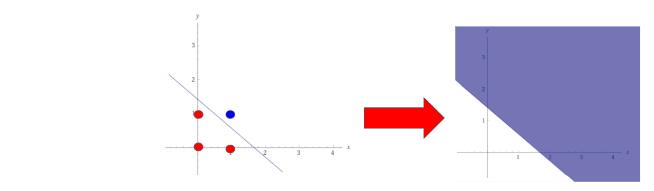

El modelo entrenado se representa con matrices de números flotantes.

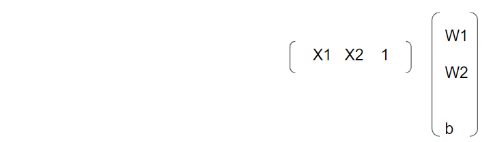

### **Limitaciones**

Solo sirve para problemas linealmente separables. Es decir, solo para problemas donde es posible trazar una linea y dividir el plano de tal forma que los conjuntos queden bien distribuidos (los rojos de un lado y los negros del otro).

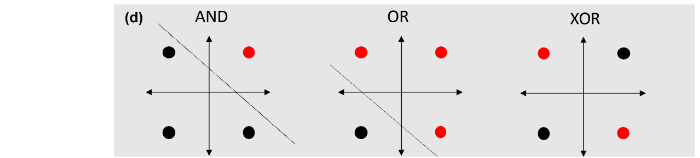

## **Perceptrón Multicapa**

Basicamente es una pila de perceptrones simples.

Se tiene una capa de entrada, $n$ capas ocultas y una capa de salida.

**Fully Connected**:
Cada neurona de una capa está conectada con todas las neuronas de la capa siguiente. Pero no está conectada con las neuronas de su misma capa, ni de 2 capas en adelante, ni de la capa de atrás.

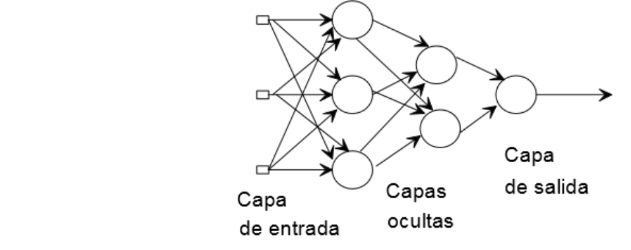

Se van a poder modelizar figuras complejas.

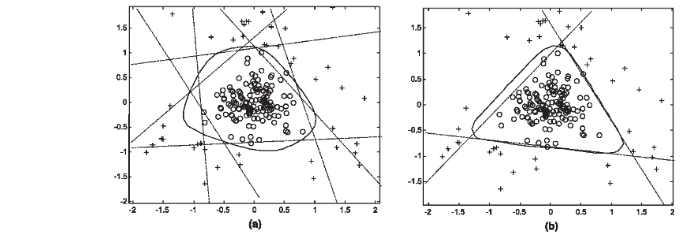

Cuanto más compleja la red (en capas o neuronas), más ciclos de entrenamiento se van a necesitar para llegar a la solución. 

**Funciones de activación.**

Se usa en la última capa cuando tengo una clasificación multi clase:
- Regresión: sigmoidea, lineal, ReLu, etc
- Clasificación de clases excluyentes: Sigmoidea \\
$\rightarrow$ se suele utilizar para representar un SÍ/NO.
- Clasificación $N$ clases simultaneas:
  - Softmax: para representar distintas categorías. Ejemplo: un libro que puede ser un poco de drama, y otro poco misterio.

No se puede utilizar la función de activación escalón ya que necesitamos que sea derivable y ésta no lo es.

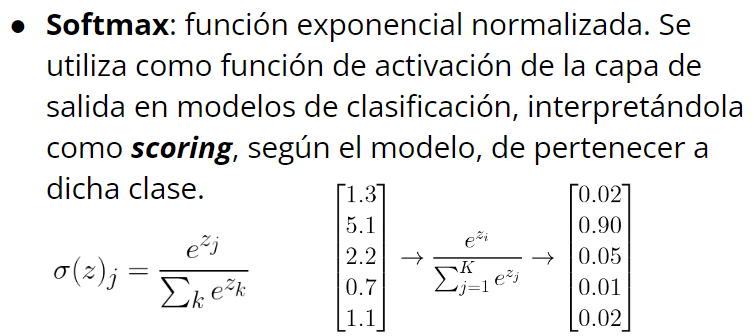

### **Backpropagation**

Algoritmo que se utiliza para entrenar redes neuronales. 

**Función de activación. Sigma:**
$$f(x) = \frac{1}{1+e^{-x}}$$


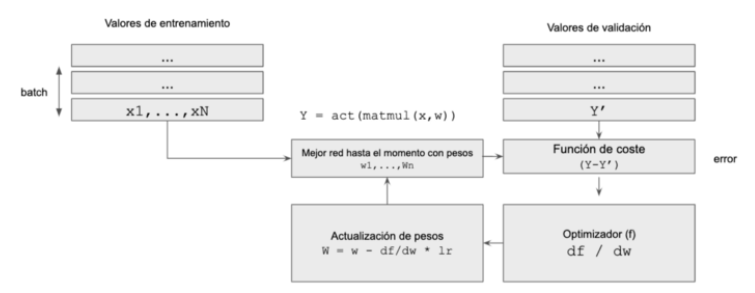

#### **Pasos**

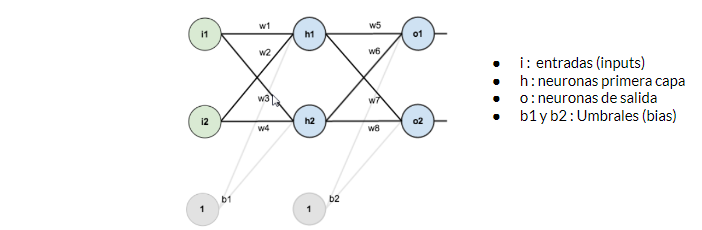

Se tienen las entradas y las salidas esperadas:


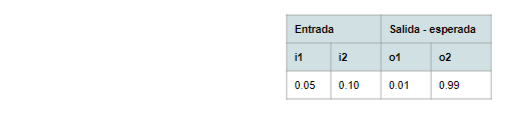

- Se tiene un modelo al que se le asignan valores al azar.


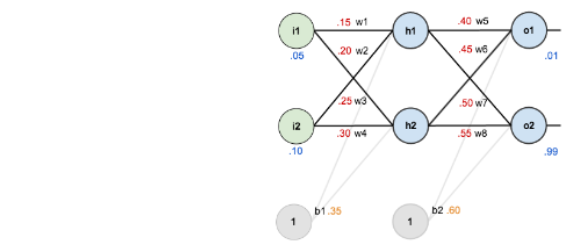

- Se calcula la entrada para $h_1$ a partir de los valores de entrada:
\begin{aligned}
net_{h_1} &= w_1 \cdot i_1 + w_2 \cdot i_2 + b_1 \cdot 1 \\
 &= 0.15 \cdot 0.05 + 0.2 \cdot 0.1 + 0.35 \cdot 1 \\
 &= 0.3775
\end{aligned}

- Se calcula la salida de $h_1$:
\begin{aligned}
out_{h_1} &= \frac{1}{1+e^{-0.3775}} \\
 &= 0.59327
\end{aligned}

- Se repiten los pasos para calcular la salida de $h_2$:
$$out_{h_2} = 0.59688$$

- Se repiten los pasos para calcular la salida de las neuronas de salida:
\begin{aligned}
net_{o_1} &= w_5 \cdot out_{h_1} + w_6 \cdot out_{h_2} + b_2 \cdot 1 \\
 &= 0.4 \cdot 0.59327 + 0.45 \cdot 0.59688 + 0.6 \cdot 1 \\
 &= 1.1059 \\
 \\
out_{o_1} &= \frac{1}{1+e^{-1.1059}} \\
 &= 0.75137 \\
 \\
\dots \\
\\
out_{o_2} &= 0.7729
\end{aligned}


- Se calcula el error cuadrático medio de cada neurona de salida:
$$E = \frac 12 (target - output)^2$$

Entonces,

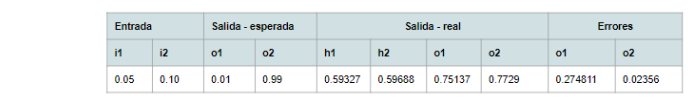

El error total es la suma de los errores
$$E_{total} = 0.29837$$

##### Se aplica **Backpropagation**

- Se calcula el gradiente del error total:
$$\overrightarrow \nabla E_{total} = (\frac{\partial E_{total}}{w_1}, \frac{\partial E_{total}}{w_2}, \frac{\partial E_{total}}{w_3}, \frac{\partial E_{total}}{w_4}, \frac{\partial E_{total}}{w_5}, \frac{\partial E_{total}}{w_6}, \frac{\partial E_{total}}{w_7}, \frac{\partial E_{total}}{w_8}).$$

La dirección de este vector apunta al máximo crecimiento de la función.

Entonces, a partir de esta información, el modelo va para el lado contrario (lado de decrecimiento).

Las derivadas parciales se calculan de atrás para adelante:

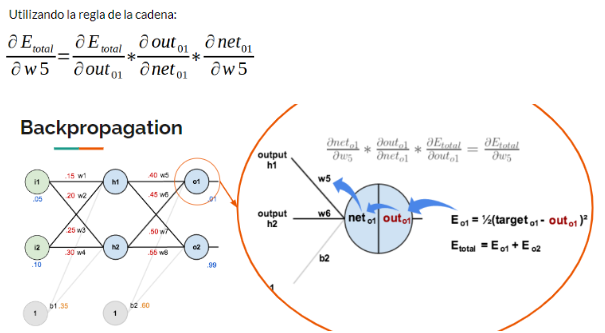

Entonces,
$$w_5' = w_5 -\alpha \cdot \frac{\partial E_{total}}{w_5}$$
con $\alpha =$ learning rate.

- Se aplica para todos los $w_i$.

Aparece un **desvanecimiento de gradiente**: a medida que se van calculando los menores $w_i$, el cambio es menor.

#### **Optimizadores**

Un optimizador es una implementación concreta del algoritmo de backpropagation

Ordenados del menos al más sofisticado (utilizan otra información además del gradiente para modificar los pesos, como derivadas segundas), los optimizadores más utilizados son:
- SGD: Stochastic Gradient Descent
- Momentum
- Nesterov
- RMSprop
- AdaGrad
- Adam
- Nadam

##### **Stochastic Gradient Descent**

Backpropagation simple, sin ningún tipo de optimización, tal y como lo vimos en clase. Algoritmo de la década de 1960.

Para implementar SGD, en Keras, tenemos que usar el optimizador SGD.

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001)

##### **Momentum**

Propuesto por Boris Polyak en 1964
Idea principal: Imaginemos una pelota rodando por una colina…

Primero irá despacio, luego irá cada vez más rápido hasta alcanzar una velocidad final constante.

A diferencia del backpropagation tradicional, en donde los pasos son regulares aquí son cada vez más rápidos. 


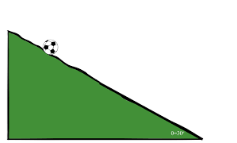

El gradiente se utiliza para la aceleración y no para la velocidad.

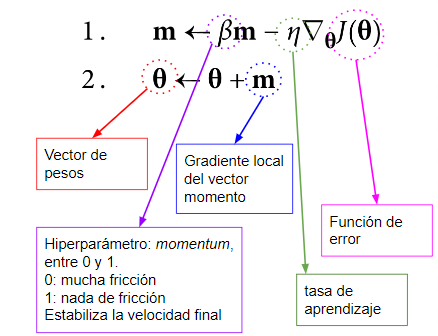

Para implementar Momentum, en Keras, tenemos que usar el optimizador SGD, con el hiperparámetro: momentum distinto de cero.

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

Lo **malo** es que añade un **nuevo hiperparámetro** que ajustar.


Lo **bueno** es que **0.9 suele funcionar bien** en la mayoría de los casos, **mejorando a Backpropagation tradicional**.


##### **Nesterov**

Propuesta por Yurii Nesterov en 1983.

Variante de Momentum, en vez de calcular el gradiente del error en el punto actual, lo calcula un poco más adelante (en la dirección del momento): θ + 𝛃m

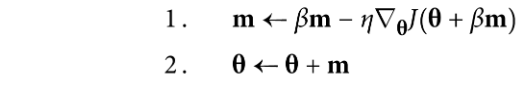

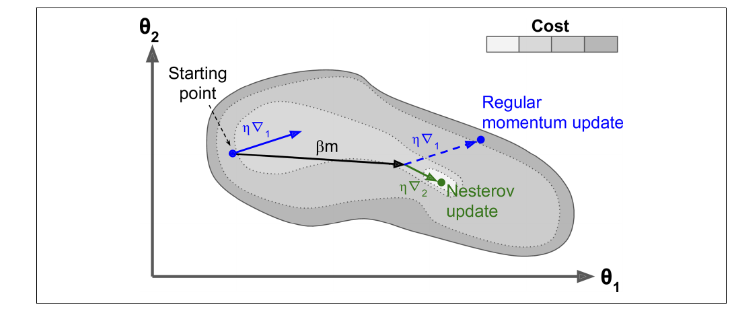

Suele converger más rápido que Momentum.

Para implementar Nesterov, en Keras, tenemos que usar el optimizador SGD, pero con la opción nesterov en True:

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

##### **AdaGrad**

Presentado por John Duchi y otros en 2011.

Uno de los problemas de los otros métodos es que en $N$ dimensiones, el error descenderá por la dimensión con la pendiente más empinada, que no necesariamente será que conduzca al mínimo global.

Esto implica que hallará primero el mínimo local (más empinado) y luego irá lentamente hacia el mínimo global.

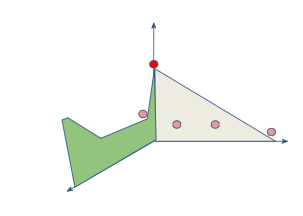

AdaGrad reduce el vector gradiente a lo largo de las dimensiones más empinadas.

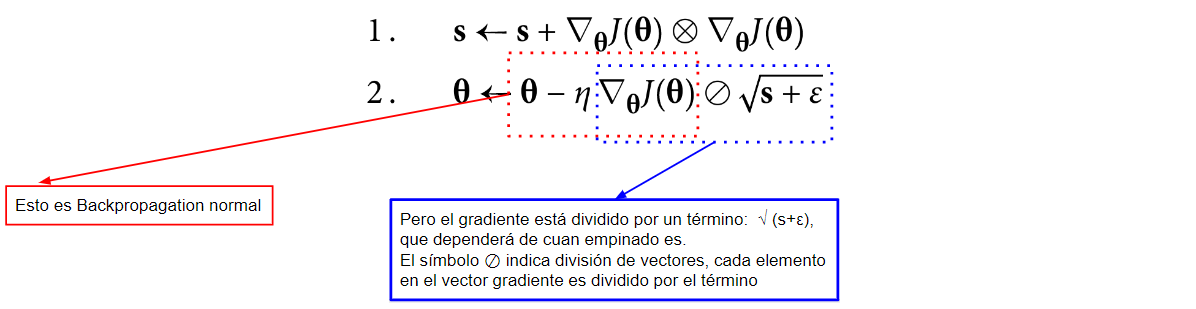

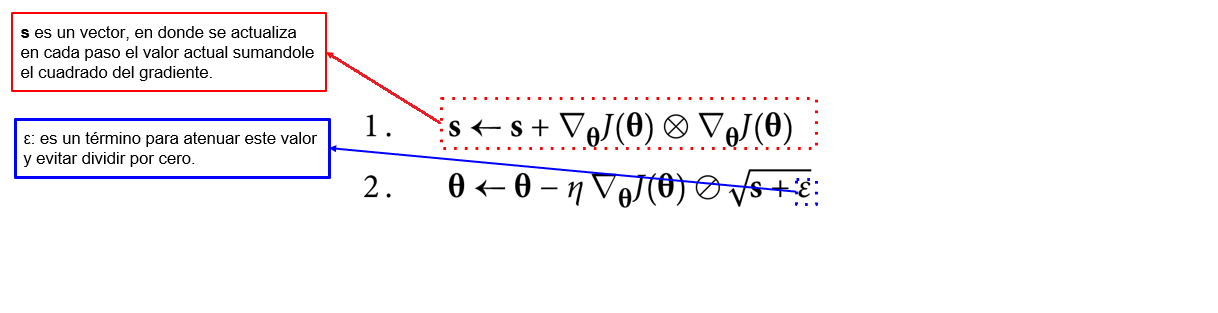

En otras palabras, cuanto más alto es el gradiente (la derivada), más empinada es la función de error en esa dimensión. Ya que el gradiente mide “la pendiente”.
Al dividir esta pendiente, por un valor proporcional a ella misma, se suaviza, y en todas las dimensiones el descenso por gradiente es similar, evitando caer en valles locales.

Ada no se desvía y corrige el rumbo hacia el mínimo global.

**Lo bueno:**

- Con frecuencia AdaGrad tiene un buen desempeño para problemas cuadráticos simples.
- Es bueno para tareas sencillas como regresión lineal.

**Lo malo:**

- A menudo se detiene demasiado pronto cuando entrena redes neuronales. Muchas veces se detiene antes de alcanzar el mínimo global.
- No debería usarse para entrenar redes profundas.

**Sirve para entender cómo funcionan otro métodos más complejos.**

$→$ No usar.

##### **RMSProp**

Creado por Geoffrey Hinton y Tijmen Tieleman en 2012

Soluciona el principal problema de AdaGrad al ir “olvidando” las pendientes anteriores, a medida que sigue avanzando. Es decir solo acumula los gradientes de las iteraciones más recientes.


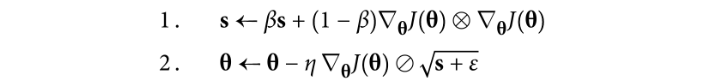

𝛽 es la tasa de decaimiento, y suele configurarse como 0.9. Es un nuevo hiperparámetro, pero suele funcionar bien con este valor predeterminado.

En Keras:

In [ ]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

$rho = 𝛽$ 

RMSProp suele ser mejor que AdaGrad y era el preferido antes de que apareciese Adam.


##### **Adam**

Adam: **Ada**ptive **m**oment estimation.

Fue presentado en 2014 por Diederik P. Kingma y Jimmy Ba.

Combina las ideas de **Momentum** y **RMSProp**.

Hace un seguimiento de una media de decaimiento exponencial de gradientes pasados y de gradientes cuadrados pasados.


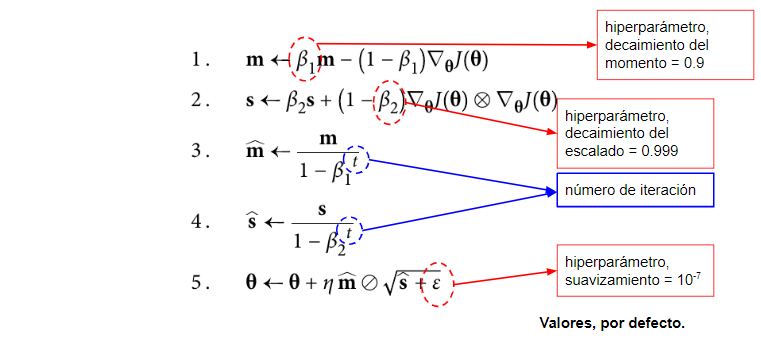

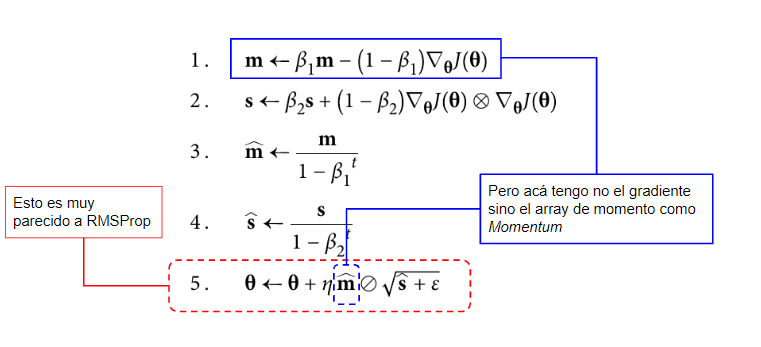

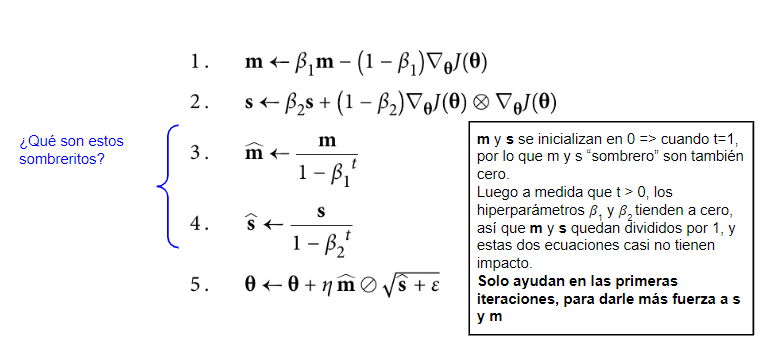

Para implementar Adam, en Keras, tenemos que usar el optimizador Adam:

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

##### **AdamMax**

AdaMax: Modificación de Adam 


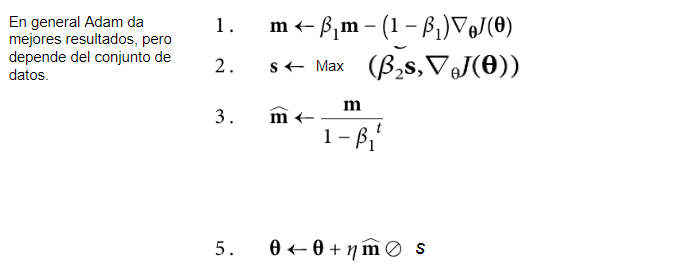

##### **Nadam**

Nadam: Es **Adam + Nesterov**, asi que a menudo converge más rápido que Adam.

##### **AdaDelta**

Adadelta: Es una **variación de AdaGrad** en la que en vez de calcular el escalado del factor de entrenamiento de cada dimensión, teniendo en cuenta el gradiente acumulado desde el principio de la ejecución, se restringe a una ventana de tamaño fijo de los últimos $n$ gradiente.

Similar a RMSProp que va olvidando los gradientes



##### **Comparación**

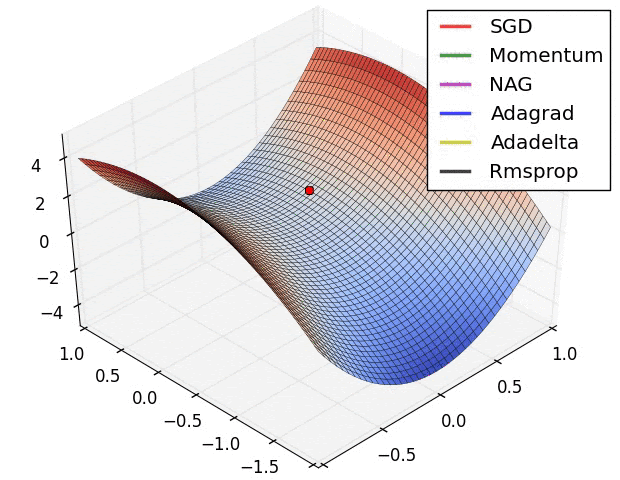

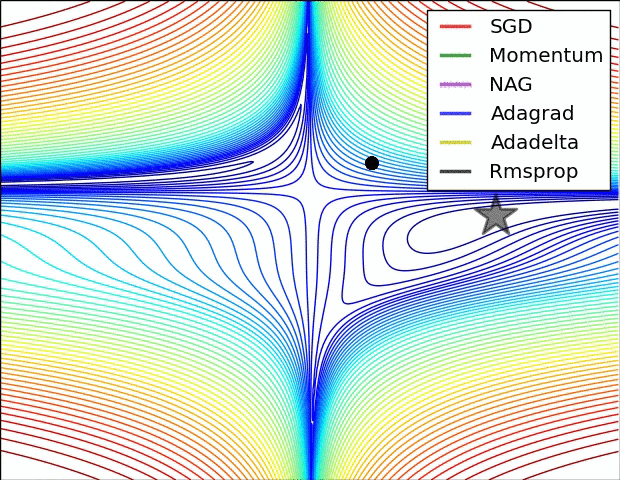

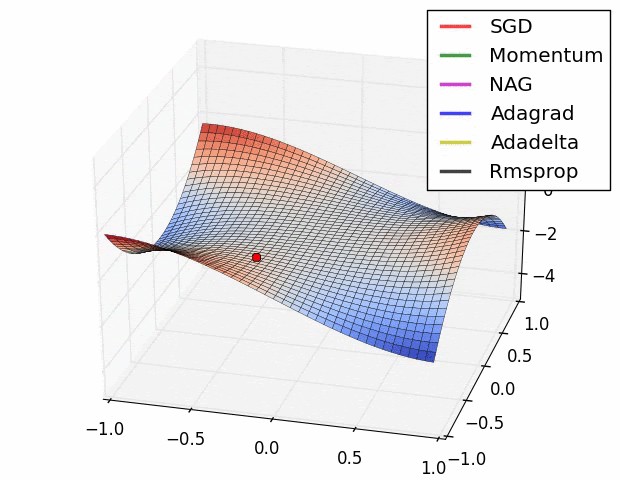

### **Número de capas**

Para muchos problemas 1 capa oculta será suficiente. En teoría un PMC con una sola capa oculta puede modelizar funciones complejas. Tendrá que tener neuronas suficientes.

Pero si estamos ante problemas más complejos, las redes profundas tendrán mejor desempeño, ya que pueden modelizar mejor con menos neuronas totales.

#### **Ejemplo**

**MNIST**: números escritos a mano. 

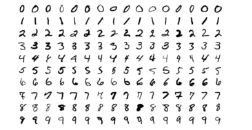

- $1$ capa oculta (cientos de neuronas) = $97\%$
- $2$ capas ocultas (mismo número de neuronas total) = $98\%$

Otros problemas como reconocimiento de imágenes o del discurso requieren decenas o cientos de capas, pero todas ellas conectadas como en PMC.

### **Número de neuronas por capa**

El número de neuronas de la capa de entrada y de salida está determinado por el problema a resolver:

#### **Ejemplo**

**MNIST**: números escritos a mano. 

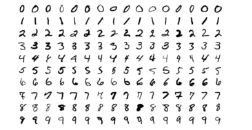

Cada número es una imagen de $28 \times 28$ píxeles $= 784$ neuronas de entrada.

Los dígitos a reconocer son los del sistema decimal tradicional. Así que son $10$, del $0$ al $9$. $10$ neuronas de salida.


Lo habitual es hacer una pirámide, poniendo cada vez menos neuronas.

Por ejemplo para MNIST, $3$ capas ocultas podrían tener: $300$, $200$ y $100$ neuronas cada una.

Sin embargo, últimamente se ha cuestionado esta técnica, ya que a veces poner la misma cantidad de neuronas en todas las capas da el mismo resultado o a veces mejor. 

### **Learning Rate**

Learning rate o tasa de aprendizaje: es el más importante, indica qué tan rápido se va desciendo en la función de costo.

Valores usuales: E-01 a E-04.


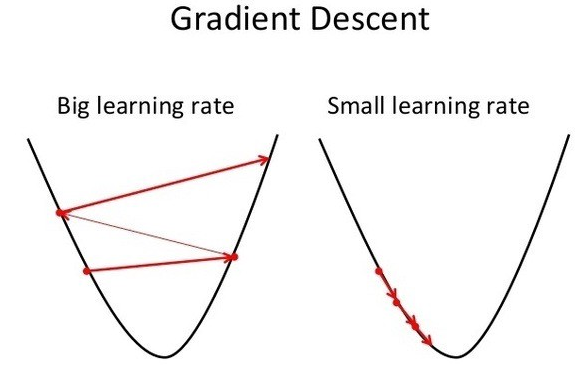

### **Problemas**

Si se tiene una red neuronal muy compleja, probablemente haya **overfitting**.

Solución:

**Métodos de Regularización.**

Son métodos que ayudan a una mejor generalización, es decir, que el modelo funcione en datos que nunca vió. Los más usados son:
- Regularización L1 y L2.
- Dropout.
- Early stopping.
- Data augmentation.


#### **Regularización L1 y L2**

Penalizan el valor de los pesos de la red. Esto evita que se le dé más relevancia a una característica que a otra. Se le agrega un término en la función de costos proporcional a los pesos. 

Si es proporcional al módulo de los pesos se llama **regularización L1**, si es proporcional al módulo cuadrado se le llama **regularización L2**.

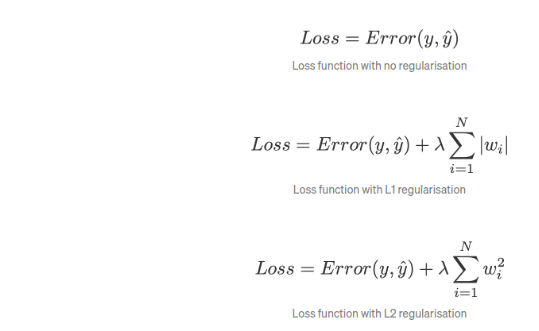

#### **Dropout**

Método de regularización que evita codependencias en las conexiones de la red. La idea es “apagar” activaciones aleatoriamente durante el entrenamiento. Esto hace que el buen funcionamiento de la red no dependa de unas pocas neuronas.

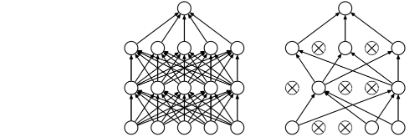

#### **Early stopping**

La idea es evitar el sobreajuste parando el entrenamiento antes de que el error del set validación empieza aumentar.

Este método busca entonces quedarse con los pesos en la instancia óptima.


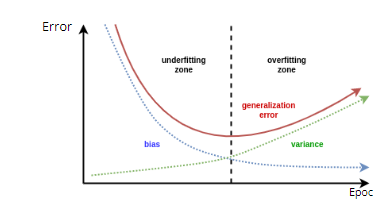

#### **Data augmentation**

La idea es agregar datos usando los datos que se tienen y aplicarles transformaciones que los conviertan en nuevos datos, de manera que sean verosímiles.

Es especialmente útil cuando se trabaja con imágenes. En general es difícil encontrar las transformaciones a aplicar.

Ejemplo:

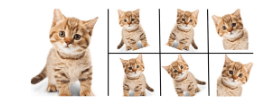

### **Simuladores**

[Ejemplo XOR](https://playground.tensorflow.org/#activation=sigmoid&regularization=L2&batchSize=30&dataset=xor&regDataset=reg-plane&learningRate=0.1&regularizationRate=0.003&noise=10&networkShape=4&seed=0.76427&showTestData=true&discretize=false&percTrainData=80&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&showTestData_hide=false)

[Ejemplo DONA](https://playground.tensorflow.org/#activation=sigmoid&regularization=L2&batchSize=30&dataset=circle&regDataset=reg-plane&learningRate=0.1&regularizationRate=0.003&noise=20&networkShape=4,3&seed=0.14921&showTestData=true&discretize=false&percTrainData=80&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&showTestData_hide=false)



## **Redes Convolucionales**

Variación de un perceptrón multicapa, sin embargo, debido a que su aplicación es realizada en matrices bidimensionales, son muy efectivas para tareas de visión artificial, como en la clasificación y segmentación de imágenes, entre otras aplicaciones.



**Arquitectura.**

Las redes neuronales convolucionales consisten en múltiples capas de filtros convolucionales de una o más dimensiones. Después de cada capa, por lo general se añade una función para realizar un mapeo causal no-lineal.

Como cualquier red empleada para clasificación, al principio estas redes tienen una  fase de extracción de características, compuesta de neuronas convolucionales , luego hay una reducción por muestreo y al final tendremos neuronas de perceptrón mas sencillas para realizar la clasificación final sobre las características extraídas.

La fase de extracción de características se asemeja al proceso estimulante en las células de la corteza visual. Esta fase se compone de capas alternas de neuronas convolucionales y neuronas de reducción de muestreo. Según progresan los datos a lo largo de esta fase, se disminuye su dimensionalidad, siendo las neuronas en capas lejanas mucho menos sensibles a perturbaciones en los datos de entrada, pero al mismo tiempo siendo estas activadas por características cada vez más complejas.

**Funcionamiento.**

Para comenzar, la red toma como entrada los pixeles de una imagen. Si tenemos una imagen con apenas $28×28$ pixeles de alto y ancho, esto equivale a  utilizar $784$ neuronas. Y eso es si sólo tenemos $1$ color (escala de grises). Si tuviéramos una imagen a color, necesitaríamos $3$ canales $RGB$ (red, green, blue) y entonces usaríamos $28×28×3 = 2352$ neuronas.

Estas neuronas constituyen nuestra capa de entrada.

**Pre-procesamiento.**

Como entrada conviene convertir los valores entre $0$ y $1$, y por tanto se tendrán que dividir todos entre $255$. Este $255$ es por que los colores de los pixeles tienen valores que van del $0$ al $255$.

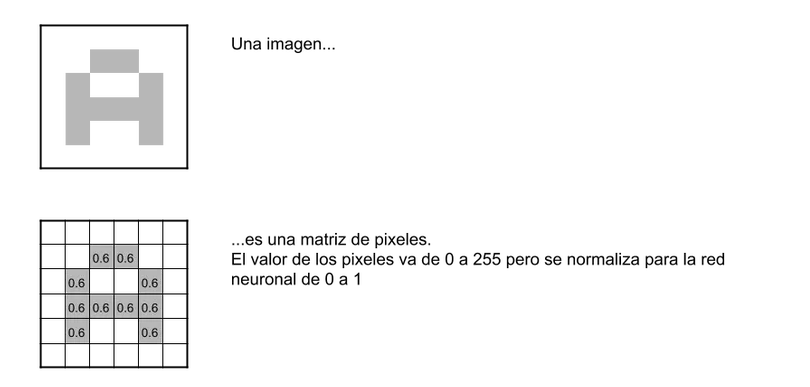

### **Convoluciones**

Consisten en tomar «grupos de pixeles cercanos» de la imagen de entrada e ir operando matemáticamente (producto escalar) contra una pequeña matriz que se llama **kernel**.

Ese kernel, por ejemplo, puede tener un tamaño de $3×3$ pixels y con ese tamaño logra «visualizar» todas las neuronas de entrada (de izquierda-derecha, de arriba-abajo) y asi genera una nueva matriz de salida, que en definitiva será la nueva capa de neuronas ocultas.

NOTA: si la imagen fuera a color, el kernel realmente sería de $3x3x3$ es decir: un filtro con $3$ kernels de $3×3$; luego esos $3$ filtros se suman (y se le suma una unidad bias) y conformará $1$ salida (cómo si fuera $1$ solo canal).

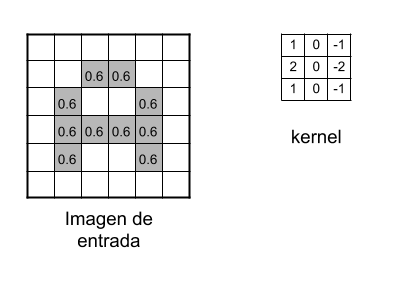

El kernel tomará inicialmente valores aleatorios y se irán ajustando mediante backpropagation.

Una mejora es hacer que al crear el kernel, éste siga una distribución normal siguiendo simetrías, pero sus valores son aleatorios.

**Filtro: conjunto de kernels**

No se aplicará $1$ sólo kernel, si no que tendremos muchos kernel (al conjunto de Kernels se les llama filtros). Por ejemplo en esta primer convolución podríamos tener $32$ filtros, con lo cual realmente obtendremos $32$ matrices de salida (este conjunto se conoce como «feature mapping»), cada una de $28\times28\times1$ dan  un total del $25.088$ neuronas para nuestra PRIMER CAPA OCULTA de neuronas, y que solo analiza  una imagen cuadrada de apenas $28$ pixeles? Imaginen cuántas más serían si tomáramos una imagen de entrada de $224\times224\times3$ (que aún es considerado un tamaño pequeño)…

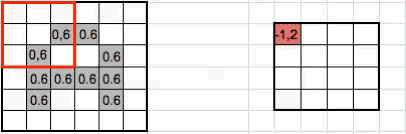

A medida que vamos desplazando el kernel y vamos obteniendo una «nueva imagen» filtrada por el kernel.  En esta primer convolución y siguiendo con el ejemplo anterior, es como si obtuviéramos 32 «imágenes filtradas nuevas». Estas imágenes nuevas lo que están «dibujando» son ciertas características de la imagen original. Esto ayudará en el futuro a poder distinguir un objeto de otro (por ej. gato ó un perro).


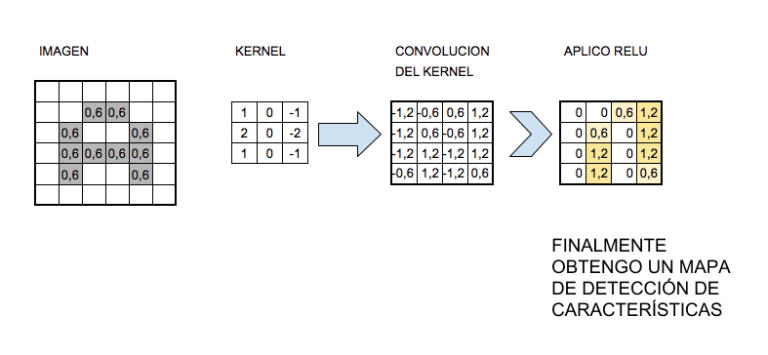

**Función de activación.**

La más utilizada es la llamada **ReLu** por Rectifier Linear Unit y consiste en una función $$f(x)=max(0, x). $$



### **Muestreo (subsampling)**



Ahora viene un paso en el que tomamos una muestra  de las neuronas mas representativas antes de hacer una nueva convolución.

¿Por qué muestreamos? Antes vimos que con  imagen blanco y negro de 28x28pixels tenemos una primer capa de entrada de 784 neuronas y luego de la primer convolución obtenemos una capa oculta de 25.088 neuronas -que realmente son nuestros 32 mapas de características de 28×28 ((28 x 28 ) x 32)

Si hiciéramos una nueva convolución a partir de esta capa, el número de neuronas de la próxima capa requeriría un poder computacional importante. Por ello y para reducir el tamaño de la próxima capa de neuronas hacemos un muestreo preservando las características más importantes que detectó cada filtro.

Hay diversos tipos de muestreo (subsampling), el más usado es: Max-Pooling.

#### **Max-Pooling**

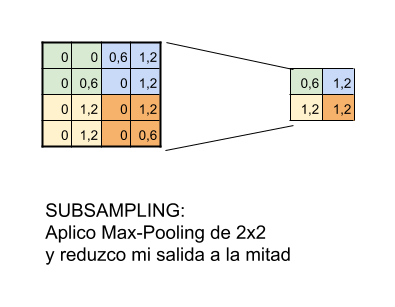

El paso siguiente sería utilizar la tecnica de  «Max-pooling» con un  tamaño de 2×2.  Esto quiere decir que recorreremos cada una de las 32 imágenes de características obtenidas anteriormente de 28x28px de izquierda-derecha, arriba-abajo PERO en vez de tomar de a 1 pixel, tomaremos de «2×2» (2 de alto por 2 de ancho = 4 pixeles) e iremos preservando el valor «más alto» de entre esos 4 pixeles (por eso lo de «Max»).  En este caso, usando 2×2, la imagen resultante es reducida «a la mitad»y quedará de 14×14 pixeles. Luego de este proceso de submuestreo nos quedarán  32 imágenes de 14×14, pasando de 25.088 neuronas a  6272, las cuales son bastantes menos y que -en teoría- deberían seguir almacenando la información más importante para detectar características deseadas.



##### **Primera Convolución**

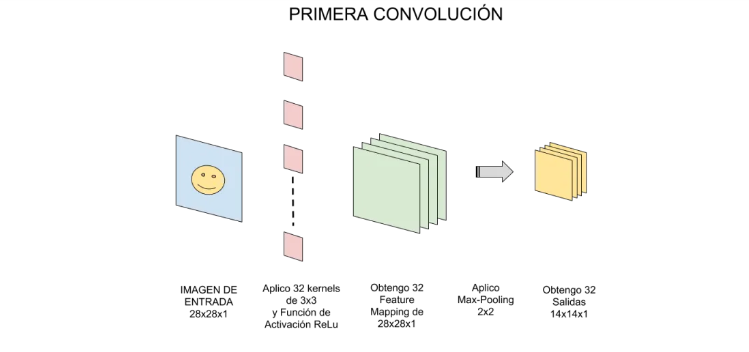

La imagen superior representa  esa primera convolución: consiste de una entrada, un conjunto de filtros, generamos un mapa de características y hacemos el submuestreo.  Con lo cual, en el ejemplo de imágenes de 1 sólo color tendremos:

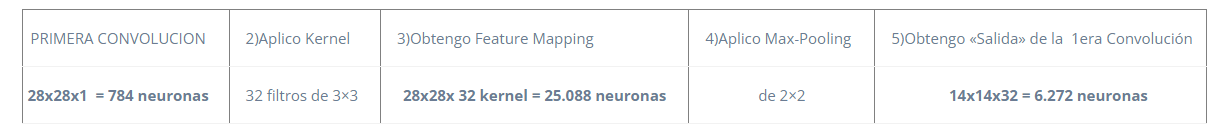

La primer convolución es capaz de detectar características primitivas como lineas ó curvas. A medida que hagamos más capas con las convoluciones, los mapas de características serán capaces de reconocer formas más complejas, y el conjunto total de capas de convoluciones podrá «reconocer».

##### **Siguientes Convoluciones**

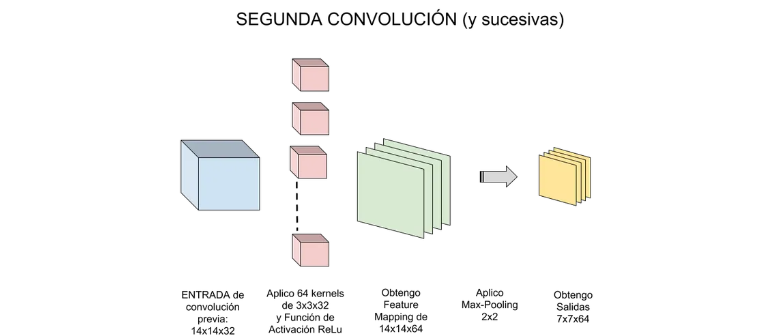

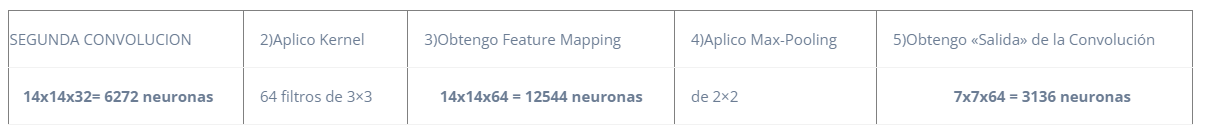

La $3er$ convolución comenzará en tamaño $7×7$ pixels y luego del max-pooling quedará en $3×3$ con lo cual podríamos hacer sólo $1$ convolución más. En este ejemplo empezamos con una imagen de $28×28$ px e hicimos $3$ convoluciones. Si la imagen inicial hubiese sido mayor (de $224×224$ px) aún hubiéramos podido seguir haciendo convoluciones.

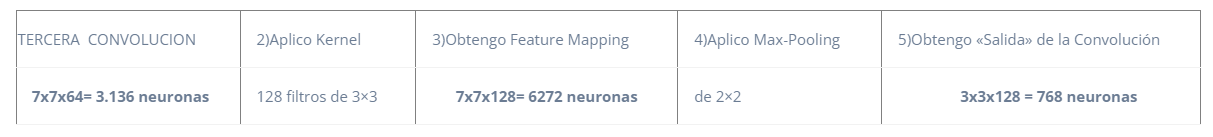

### **Código**

In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop

Vamos a usar Keras, específicamente la clase [Sequential](https://keras.io/api/models/sequential/).

Con `Sequential` podemos construir una arquitectura en la que se apilan capas de manera secuencial.

In [ ]:
model = Sequential()

Arquitectura a realizar:

> **In -> [[Conv2D->relu]* 2 -> MaxPool2D -> Dropout]* 2 -> Flatten -> Dense -> Dropout -> Out**

In [ ]:
#Inicialmente se indican las dimensiones del input

model.add(Conv2D(filters = 32,
                 kernel_size = (5,5),
                 padding = 'Same', #padding con 0's
                 activation = 'relu',
                 input_shape = (28, 28, 1)))

model.add(Conv2D(filters = 32,
                 kernel_size = (5,5),
                 padding = 'Same', #padding con 0's
                 activation = 'relu')) 

Hacemos un "maxpooling": agregamos a nuestro modelo un [MaxPool2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/)

In [ ]:
model.add(MaxPool2D(pool_size = (2, 2)))

Agregamos una capa de Dropout

In [ ]:
model.add(Dropout(rate = 0.25)) # rate === fracción de neuronas a anularse

Repetimos, pero esta vez reduciendo el tamaño del kernel en las capas de convolución a `(3x3)`

In [ ]:
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

In [ ]:
#se colocan los datos en un array
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))
model.summary()

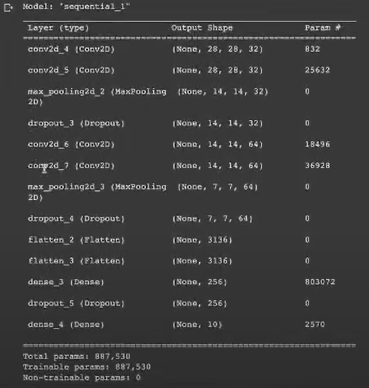

In [ ]:
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
epochs = 10 # Para mayor precisión, incrementar el número de epochs
batch_size = 86

❗ En Colab ir a "Edit" -> "Notebook settings" -> "Hardware acceleration" y habilitar el uso de la GPU! Acelera mucho el entrenamiento.

In [ ]:
history = model.fit(datagen.flow(training_digits, training_labels, batch_size=batch_size),
                              epochs = epochs, validation_data = (validation_digits, validation_labels),
                              verbose = 2, steps_per_epoch=training_digits.shape[0] // batch_size)

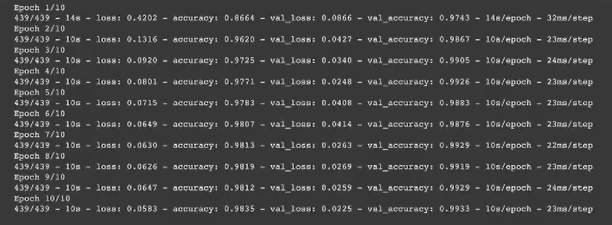

##**Redes SOM (Kohonen)**

Se va a mapear un espacio de entrada a través de los pesos en una capa de salida que tiene varias neuronas de ancho y de alto.

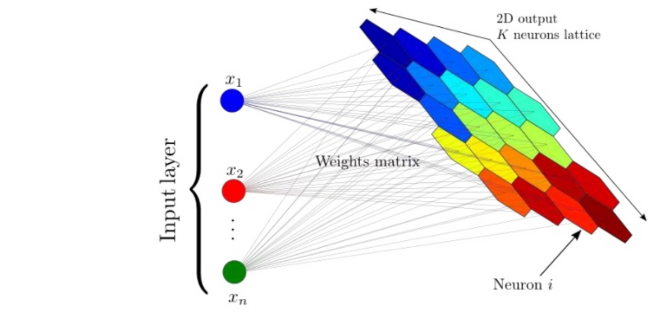

La idea es similar a K-means, en donde se dividen los datos por conjuntos con características similares.

En este caso, no se indica la cantidad de conjuntos a formar, ya que al tener $n \times n$ neuronas de salids, se van a ir mapeando los valores de entrada y agrupando de forma cercana unos a otros según sus similitudes.

Se tienen dos tipos de capas:
- **Visible Input Nodes**: capa de entrada
- **Visible Output Nodes (Map)**: capa de salida que representa una matriz

Una neurona de la capa de entrada conecta con una neurona de la capa de salida a través de sus pesos.

Es decir, la neurona $3$ conecta con la neurona $4$ a través del peso $w_{4,3}$.

A partir de esos pesos, se calcula la distancia entre los valores de entrada y los de salida.

Siendo $i$ el $n°$ de la neurona de la capa de entrada y $j$ el $n°$ de la neurona de la capa de salida  $$distancia(capa\_entrada, neurona\_capa\_de\_salida) = \sqrt{\sum_{i=1}^n{(x_i - w_{j,i})}^2}$$

Se mira la neurona con la menor distancia.

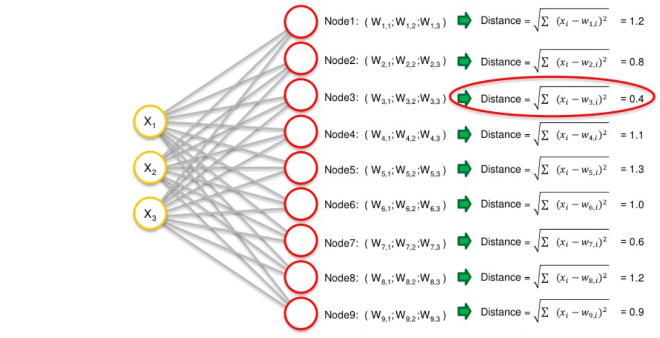

Es decir, en cada ciclo de entrenamiento se va a tener una sola neurona ganadora, que va a ser la que esté a la menor distancia del punto de entrada.

Existe un **área de vecindad** a partir de la cual se van a buscar todas las neuronas vecinas a esa y se les van a actualizar sus pesos.

Esa área va a ir disminuyendo a través del entrenamiento, hasta que sea cada vez más pequeña.

Finalmente, los datos se van a tener mapeados en diferentes áreas.

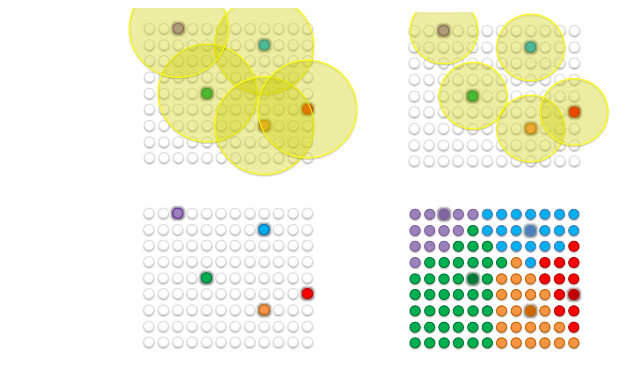

## **Código**

Entrenar la red neuronal requiere establecer:

Arquitectura $+$ Hiperparámetros $+$ Optimizador $+$ Función de pérdida $+$ Funciones de activación.



**Bibliotecas**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import visualkeras

np.random.seed(1)
tf.random.set_seed(1) 

### **Clasificación**

En este ejemplo se intenta predecir el target en función de dos features

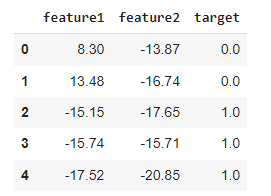

Se normalizan las variables

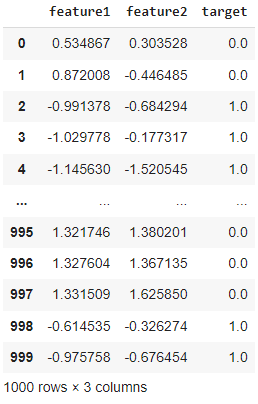

Creación y entrenamiento del modelo

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dataset_trabajo.loc[:,columnas_predictoras], dataset_trabajo.loc[:,'target'], test_size=0.8)

En este caso, los calculos de pesos a calcular por capa son:

- Para la primera capa, de $3$ neuronas:
  - Para cada neurona,
    - un peso por cada columna,
    - un bias por neurona.

Si se tienen $2$ columnas, entonces la primera capa requerirá de $(2 + 1) \cdot 3 = 9$ parámetros.

Cada neurona tendrá una salida, es decir que en total habrán $3$ salidas.

- Para la segunda capa, de $5$ neuronas:
  - Para cada neurona,
    - un peso por cada entrada (que corresponden a las $3$ salidas anteriores),
    - un bias por neurona.

Entonces, la segunda capa requerirá de $(3 + 1) \cdot 5 = 20$ parámetros.

Cada neurona tendrá una salida, es decir que en total habrán $5$ salidas.

- Para la última capa, habrá $2$ neuronas:
  - Para cada neurona,
    - un peso por cada entrada (que corresponden a las $5$ salidas anteriores),
    - un bias por neurona.

Entonces, la última capa requerirá de $(5 + 1) \cdot 2 = 12$ parámetros.

En total se necesitarán calcular $41$ parámetros.



In [ ]:
# calcula la cantidad de clases
classes=int(dataset_trabajo.loc[:,'target'].max()+1)

modelo = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 3 salidas, activación relu
    keras.layers.Dense(3,input_shape=(d_in,), activation='relu'),
    # Capa con 5 salidas, activación tanh
    keras.layers.Dense(5, activation='tanh'),
    #la ultima capa si o si tiene que tener tantas salidas como clases, y softmax 
    keras.layers.Dense(classes, activation='softmax')])

modelo.summary()

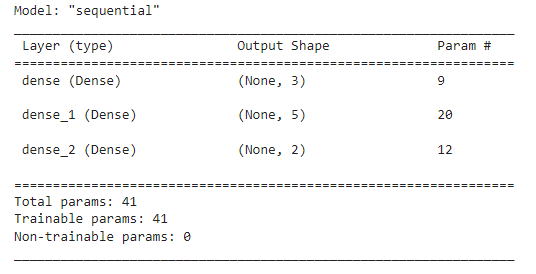

In [ ]:
plot_clasificador(modelo,x_train,y_train,title=f"Modelo inicial",detail=0.05)

In [ ]:
modelo.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.1), 
  loss='sparse_categorical_crossentropy', 
  metrics=['accuracy'], 
)

# Entrenamiento del modelo
history = modelo.fit(x_train,y_train,epochs=100,batch_size=8,verbose=False)

Este es el numero de veces que se ejecutaran los algoritmos de forwardpropagation y backpropagation. En cada ciclo (epoch) todos los datos de entrenamiento pasan por la red neuronal para que esta aprenda sobre ellos, si existen 10 ciclos y 1000 datos, cada ciclo los 1000 datos pasaran por la red neuronal. Si se especifica el parametro batch size cada ciclo (epoch) tendra más ejecuciones internas, estas ejecuciones se llaman iteraciones, si tenemos un batch size de 100, se tendran 10 iteraciones para completar un ciclo, en cada iteración se ejecutan los algoritmos de forwardpropagation y backpropagation, de esta manera la red neuronal actualiza más veces los parametros W (pesos) y b (bias).

Para visualizar mejor:

In [ ]:
# imprime los puntos para un dataset junto con la frontera de decisión del modelo
def plot_clasificador(modelo, x, y,title="",detail=0.1):
   
    # nueva figura
    plt.figure()
    # gráfico con la predicción aprendida
    x_min, x_max = x.iloc[:, 0].min() - 1, x.iloc[:, 0].max() + 1
    y_min, y_max = x.iloc[:, 1].min() - 1, x.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, detail),
                         np.arange(y_min, y_max, detail))

    Z = np.c_[xx.ravel(), yy.ravel()]
    
    Z = modelo.predict(Z)
    Z = Z.argmax(axis=1) 
    titulo = f"{title}: regiones de cada clase"
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)  # ,  cmap='RdBu')
    plt.colorbar()
    plt.title(titulo)

    # puntos con las clases
    plt.scatter(x.iloc[:, 0], x.iloc[:, 1], c=y)

In [ ]:
plot_clasificador(modelo,x_train,y_train,title=f"Modelo Final Train",detail=0.05)
plot_clasificador(modelo,x_test,y_test,title=f"Modelo Final Test",detail=0.05)

In [ ]:
y_pred = modelo.predict(x_test)

### **Regresión**

En este ejemplo se intenta predecir el consumo de un vehículo con base en la cantidad de caballos de fuerza.

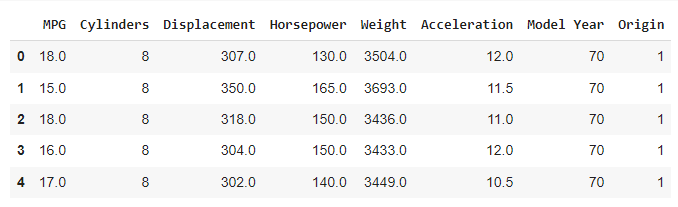

Se normalizan las variables

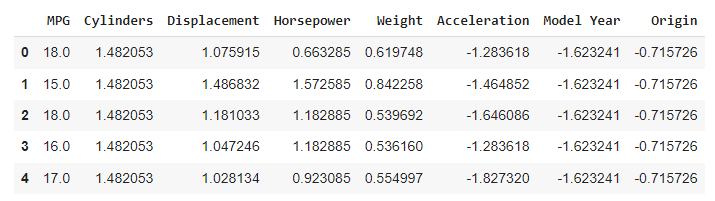

Creación y entrenamiento del modelo

In [ ]:
d_in=1
d_out=1
x_train, x_test, y_train, y_test = train_test_split(dataset_trabajo.loc[:,variable_predictora],dataset_trabajo.loc[:,'MPG'],test_size=0.2)

En este caso, los calculos de pesos a calcular por capa son:

- Para la primera capa, de $2$ neuronas:
  - Para cada neurona,
    - un peso por cada columna,
    - un bias por neurona.

Como se tiene $1$ columna, entonces la primera capa requerirá de $(1 + 1) \cdot 2 = 4$ parámetros.

Cada neurona tendrá una salida, es decir que en total habrán $2$ salidas.

- Para la segunda capa, de $2$ neuronas:
  - Para cada neurona,
    - un peso por cada entrada (que corresponden a las $2$ salidas anteriores),
    - un bias por neurona.

Entonces, la segunda capa requerirá de $(2 + 1) \cdot 2 = 6$ parámetros.

Cada neurona tendrá una salida, es decir que en total habrán $2$ salidas.

- Para la última capa, habrá $1$ neurona con:
  - un peso por cada entrada (que corresponden a las $2$ salidas anteriores),
  - un bias.

Entonces, la última capa requerirá de $(2 + 1) \cdot 1 = 3$ parámetros.

En total se necesitarán calcular $13$ parámetros.



In [ ]:
# Se crea un modelo Red Neuronal

modelo = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 2 salidas, activación relu
    keras.layers.Dense(2,input_shape=(d_in, ), activation="relu"),
    # Capa con 2 salidas, activación tanh
    keras.layers.Dense(2, activation="tanh" ),
    keras.layers.Dense(d_out, )])

modelo.summary()

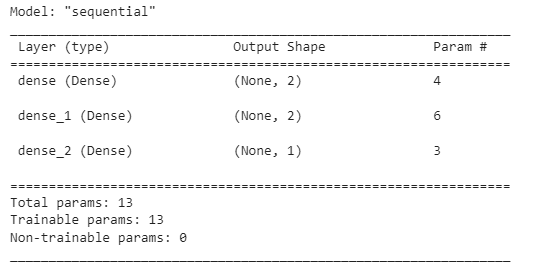

In [ ]:
plot_regression(modelo,x_train,y_train,title=f"Modelo inicial",xlabel="Horsepower",ylabel="MPG")

In [ ]:
modelo.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.001), 
  loss='mse', 
  # metricas para ir calculando en cada iteracion o batch 
  metrics=['mae'], 
)

# Entrenamiento del modelo
modelo.fit(dataset_trabajo.loc[:,variable_predictora],dataset_trabajo.loc[:,'MPG'],epochs=100,batch_size=16,verbose=False)

Este es el numero de veces que se ejecutaran los algoritmos de forwardpropagation y backpropagation. En cada ciclo (epoch) todos los datos de entrenamiento pasan por la red neuronal para que esta aprenda sobre ellos, si existen 10 ciclos y 1000 datos, cada ciclo los 1000 datos pasaran por la red neuronal. Si se especifica el parametro batch size cada ciclo (epoch) tendra más ejecuciones internas, estas ejecuciones se llaman iteraciones, si tenemos un batch size de 100, se tendran 10 iteraciones para completar un ciclo, en cada iteración se ejecutan los algoritmos de forwardpropagation y backpropagation, de esta manera la red neuronal actualiza más veces los parametros W (pesos) y b (bias).

Para visualizar mejor:

In [ ]:
def plot_regression(modelo,x,y,title="",xlabel="x",ylabel="y"):
    plt.figure()
    
    plt.plot(x,y,"o",label="Valores verdaderos")
    plt.plot(x,modelo.predict(x),"x",label="Valores estimados")
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
plot_regression(modelo,x_train,y_train,title=f"Modelo Final",xlabel="Horsepower",ylabel="MPG")
plot_regression(modelo,x_test,y_test,title=f"Modelo Final",xlabel="Horsepower",ylabel="MPG")

In [ ]:
y_pred=modelo.predict(x_test)

mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)